# ARIMA and Seasonal ARIMA

### Autoregressive Integrated Moving Averages

# The general process for ARIMA models is the following:

Visualize the Time Series Data

Make the time series data stationary

Plot the Correlation and AutoCorrelation Charts

Construct the ARIMA Model or Seasonal ARIMA based on the data

Use the model to make predictions

Let's go through these steps!

In [75]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore') #to ignore if any warnings takes place during the run time.
import statsmodels.api as sm
from flask import Flask, request,make_response,jsonify
from flask_cors import CORS
import os
app = Flask(__name__)
CORS(app)
app.config['SECRET_KEY'] = '7d123427d441f27567d441f2b6176a'
port = int(os.getenv('PORT', 8080))


In [76]:
#read the data
df=pd.read_csv('train.csv')
print("Shape of the dataset",df.shape)
df.head()

Shape of the dataset (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [77]:
df.store.nunique()

10

In [78]:
print("No of unique store is {} and store details are {}".format(df.store.nunique(),df.store.unique()))

No of unique store is 10 and store details are [ 1  2  3  4  5  6  7  8  9 10]


In [79]:
print("No of unique items are {} and item details are {}".format(df.item.nunique(),df.item.unique()))

No of unique items are 50 and item details are [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [80]:
#check for missing values in train data
df.isnull().sum()
#No missing valuues

date     0
store    0
item     0
sales    0
dtype: int64

In [81]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d") #If need extract year, month and day to new columns:

# per 1 store, 1 item
train_df = df[df['store']==1]
train_df = train_df[df['item']==1]

# train_df = train_df.set_index('date')
train_df['year'] = df['date'].dt.year
train_df['month'] = df['date'].dt.month
train_df['day'] = df['date'].dt.dayofyear
train_df['weekday'] = df['date'].dt.weekday

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


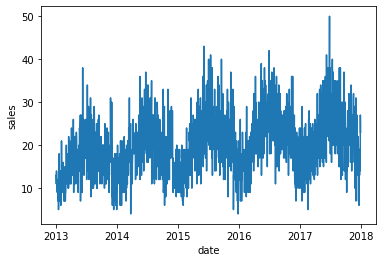

In [82]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

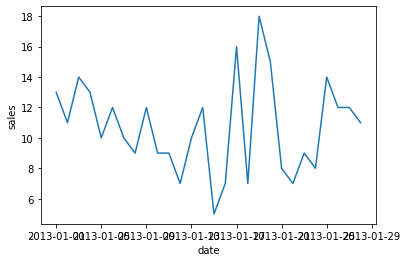

In [83]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

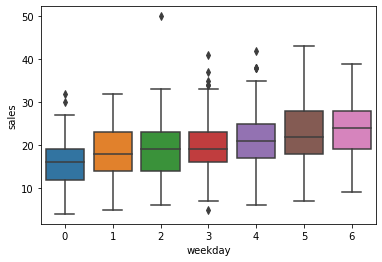

In [84]:
sns.boxplot(x="weekday", y="sales", data=train_df) 



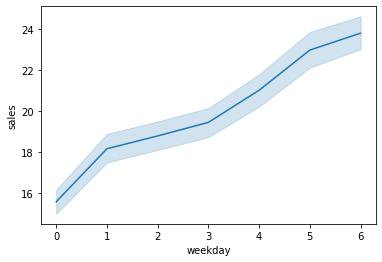

In [85]:
sns.lineplot(x="weekday", y="sales", data=train_df)

In [86]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


<Figure size 432x288 with 0 Axes>

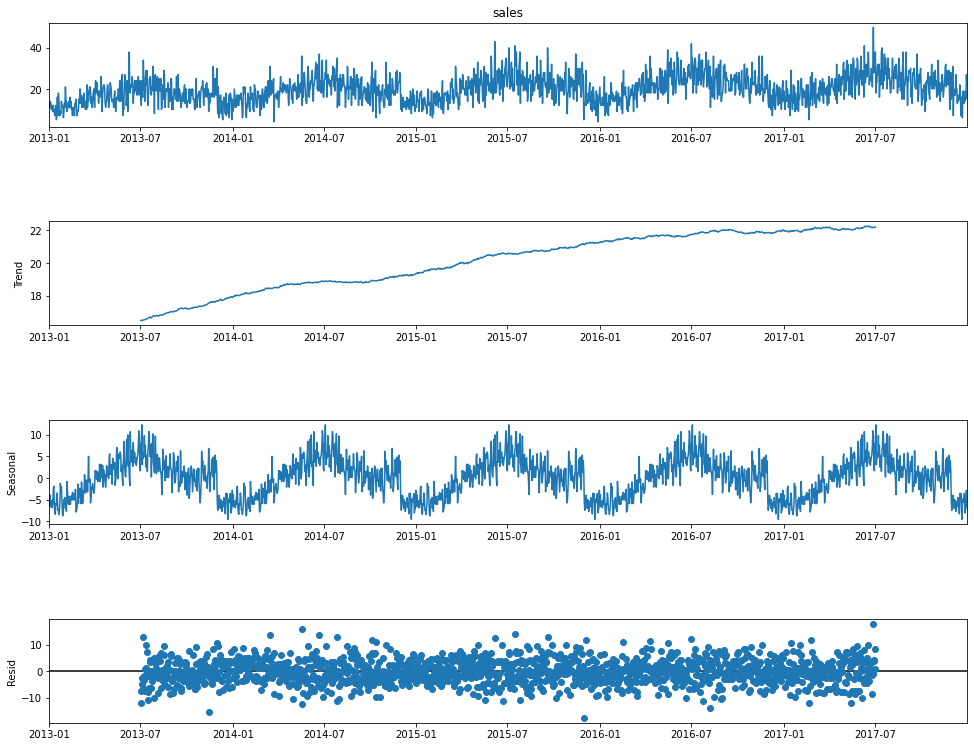

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [88]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    
  #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    fig= plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries, color='orange',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    
      #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

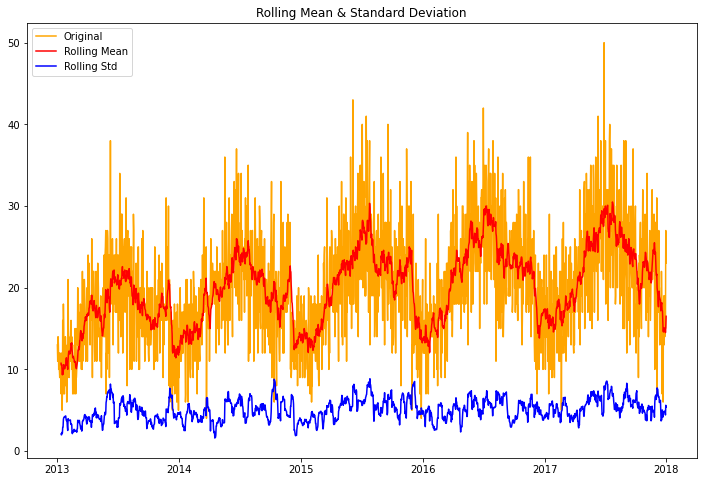

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [89]:
test_stationarity(train_df['sales'])

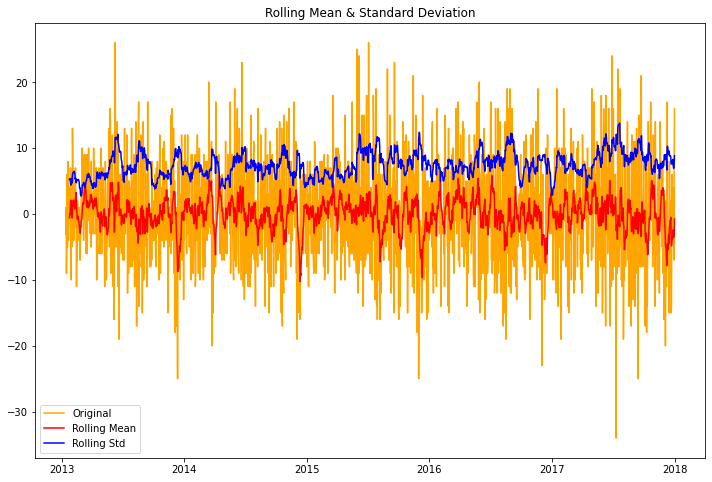

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.624608e+00
p-value                        2.084687e-11
#Lags Used                     2.000000e+01
Number of Observations Used    1.793000e+03
Critical Value (1%)           -3.434002e+00
Critical Value (5%)           -2.863153e+00
Critical Value (10%)          -2.567629e+00
dtype: float64


In [90]:
#this is for reducing trend and seasonality
first_diff = train_df.sales - train_df.sales.shift(12)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

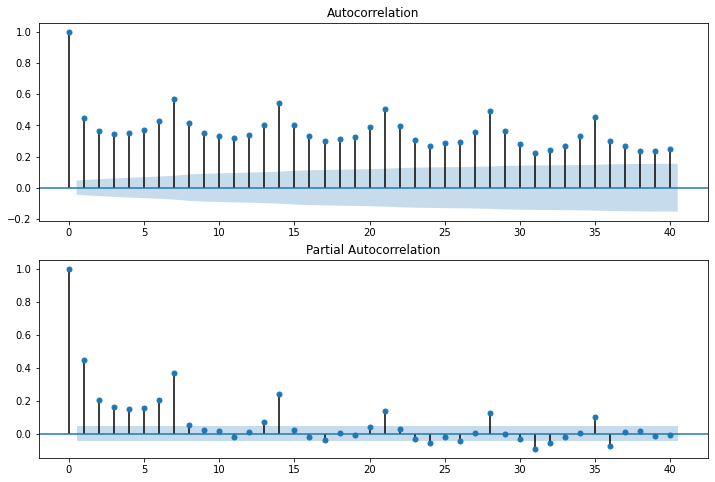

In [91]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)      #lags=40

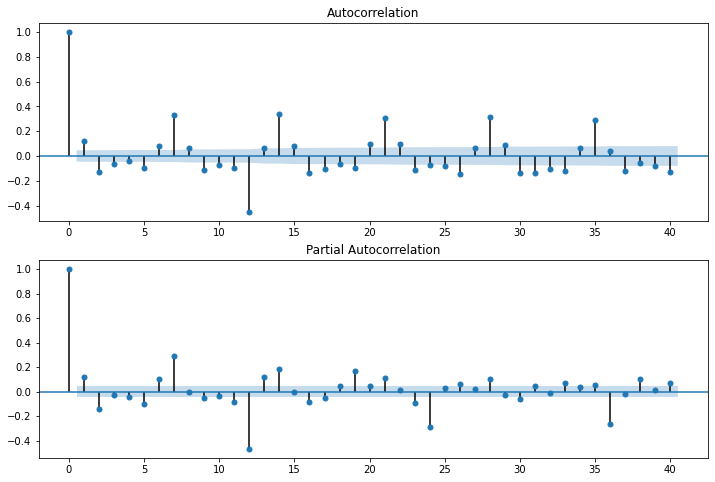

In [92]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

# Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. 
# Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of 
# significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont

In [93]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Tue, 01 Sep 2020   AIC                          11211.335
Time:                        07:51:46   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

NormaltestResult(statistic=16.426387408660936, pvalue=0.00027105367219061295)


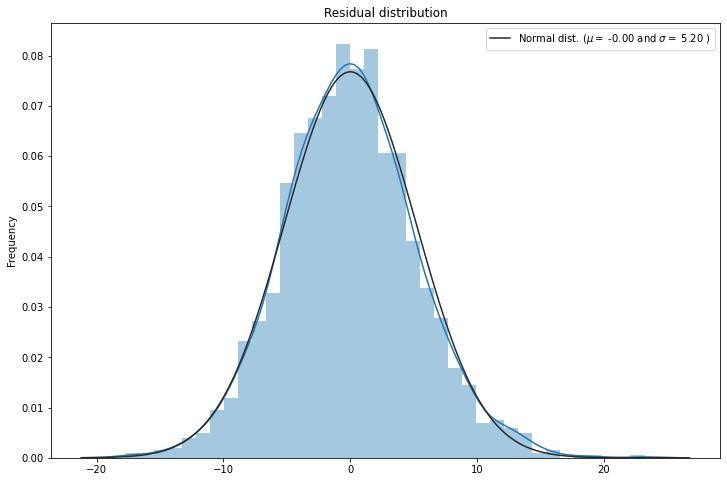

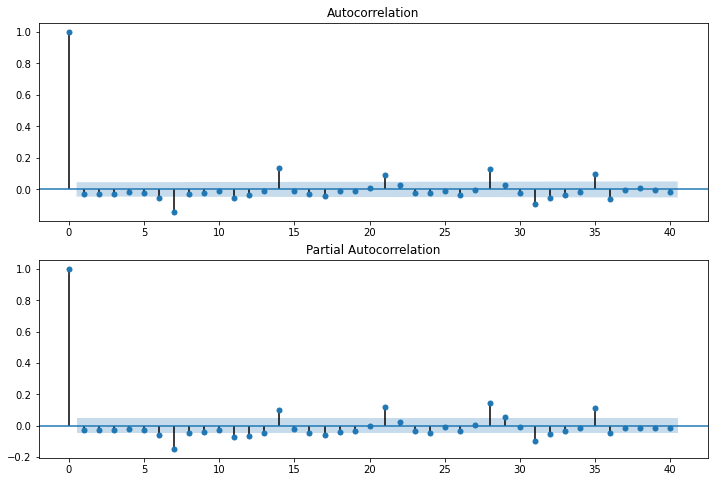

In [94]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)


In [95]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Tue, 01 Sep 2020   AIC                          11209.359
Time:                        07:51:48   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.426387408660936, pvalue=0.00027105367219061295)


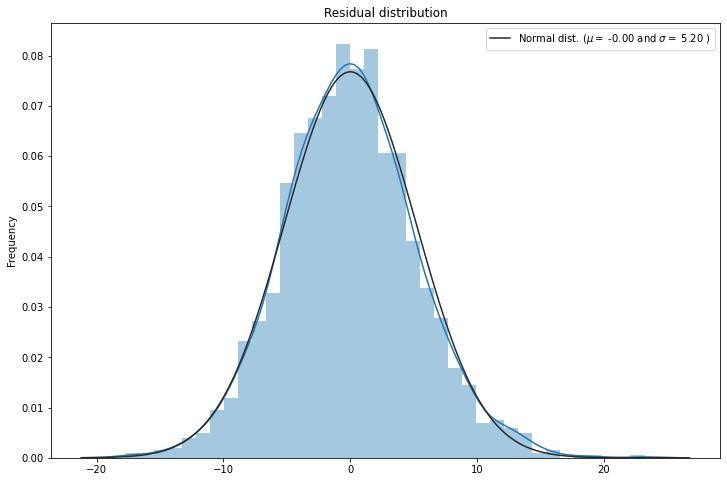

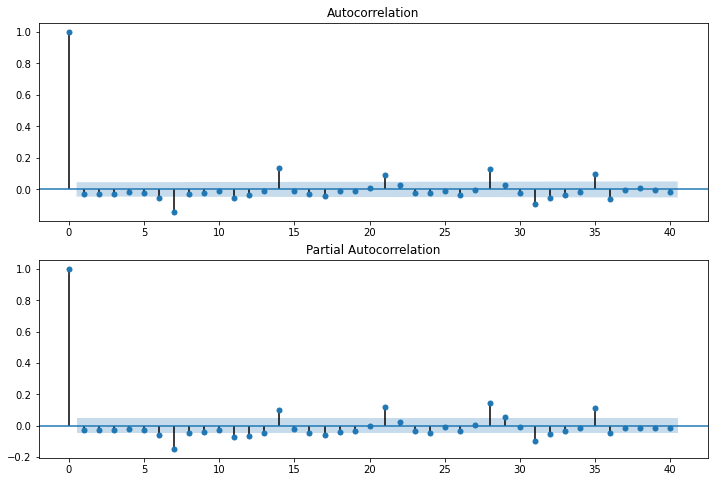

In [96]:
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

In [97]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']]

,sales,forecast
date,,
2017-09-27,27.0,21.476511
2017-09-28,23.0,22.679578
2017-09-29,28.0,25.785755
2017-09-30,30.0,27.797126
2017-10-01,21.0,22.653480
...,...,...
2017-12-27,14.0,22.661689
2017-12-28,19.0,22.661656
2017-12-29,15.0,22.661591


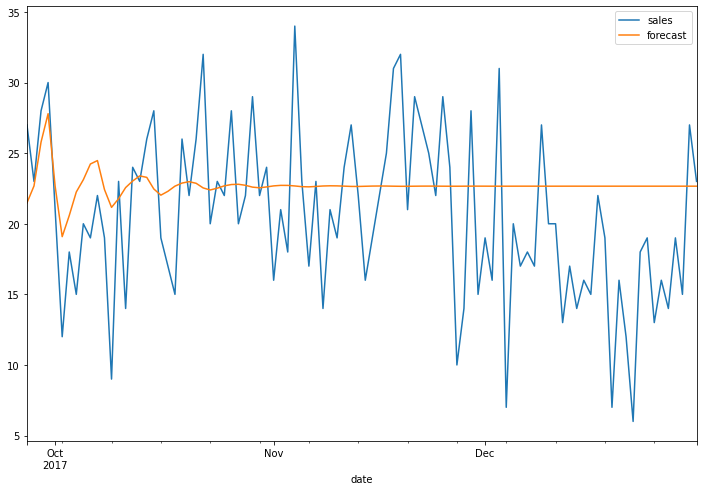

In [98]:
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [99]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")


In [100]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


In [101]:
df=pd.DataFrame()
start_index = 1730
end_index = 1826
df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True) 



In [102]:
df

,forecast
2017-09-27,21.476511
2017-09-28,22.679578
2017-09-29,25.785755
2017-09-30,27.797126
2017-10-01,22.653480
...,...
2017-12-28,22.661656
2017-12-29,22.661591
2017-12-30,22.661547
2017-12-31,22.661550


In [103]:
@app.route('/predict_sales', methods = ['POST'])
def predict_forcast(): 
        
    df=pd.DataFrame()
   
    if request.method == 'POST': 
      
        data = request.get_json()
        print(data)
        start_index = data.get('start_index')
        end_index =data.get('end_index')
        df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
        #df=df[start_index:end_index][[ 'forecast']]
        print(df)
        resultJSON = df.to_json(orient='records')
    return make_response(jsonify(resultJSON), 200)
app.run( host='0.0.0.0',port=port, debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:8080/ (Press CTRL+C to quit)
127.0.0.1 - - [01/Sep/2020 07:51:57] "POST /predict_sales HTTP/1.1" 200 -


{'start_index': 1730, 'end_index': 1826}
             forecast
2017-09-27  21.476511
2017-09-28  22.679578
2017-09-29  25.785755
2017-09-30  27.797126
2017-10-01  22.653480
...               ...
2017-12-28  22.661656
2017-12-29  22.661591
2017-12-30  22.661547
2017-12-31  22.661550
2018-01-01  22.661589

[97 rows x 1 columns]
